In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from utils import *

In [2]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [3]:
target = 'category'
fake_data_name = 'e4e_00005_snapshot_1200'
retrain = False

### 1. Prepare Data

In [4]:
train_real, test_real = prepare_data(target, 'real_images_embeddings')
train_fake, test_fake = prepare_data(target, fake_data_name)

# Combine real and fake data
train = ConcatDataset([train_real, train_fake])
test = ConcatDataset([test_real, test_fake])

print(f"Target: {train_real.target}")
print(f"\tNumber of classes: {len(train_real.id2label)}")

print(f"\tNumber of training samples: {len(train)}")
print(f"\tNumber of testing samples: {len(test)}")

Target: category
	Number of classes: 8
	Number of training samples: 22496
	Number of testing samples: 5624


### 2. Training

In [5]:
## Model Parameters
embeddings_shape = train_real[0][0].shape[0]
num_classes = len(train_real.id2label)

## Training Hyperparameters
NUM_EPOCHS = 30
BATCH_SIZE = 128
LR = 5e-4
loss_fn = nn.CrossEntropyLoss()

## Initialize Model and Optimizer
device = set_device()
model = ClassifierModel(embeddings_shape, num_classes)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=LR)

model_save_path = f"{DATA_PATH}/Models/Assessor/DinoV2/Classifier/{target}_{fake_data_name}.pt"

Using cpu as device


Initial Train Accuracy: 0.0527649359886202, Initial Test Accuracy: 0.05352062588904694
Epoch 1/30, Loss: 1.122595191001892, Train Accuracy: 0.6258890469416786, Test Accuracy: 0.6109530583214794
Epoch 2/30, Loss: 1.1054543256759644, Train Accuracy: 0.6383801564722618, Test Accuracy: 0.6177098150782361
Epoch 3/30, Loss: 1.0829031467437744, Train Accuracy: 0.6619843527738265, Test Accuracy: 0.6372688477951636
Epoch 4/30, Loss: 0.892248809337616, Train Accuracy: 0.6647403982930299, Test Accuracy: 0.6289118065433855
Epoch 5/30, Loss: 0.857546329498291, Train Accuracy: 0.6793652204836416, Test Accuracy: 0.6401137980085349
Epoch 6/30, Loss: 0.8223056793212891, Train Accuracy: 0.6912339971550497, Test Accuracy: 0.6413584637268848
Epoch 7/30, Loss: 0.8764739632606506, Train Accuracy: 0.704925320056899, Test Accuracy: 0.642425320056899
Epoch 8/30, Loss: 0.9786562919616699, Train Accuracy: 0.7123044096728307, Test Accuracy: 0.6426031294452347
Epoch 9/30, Loss: 0.7841090559959412, Train Accuracy: 

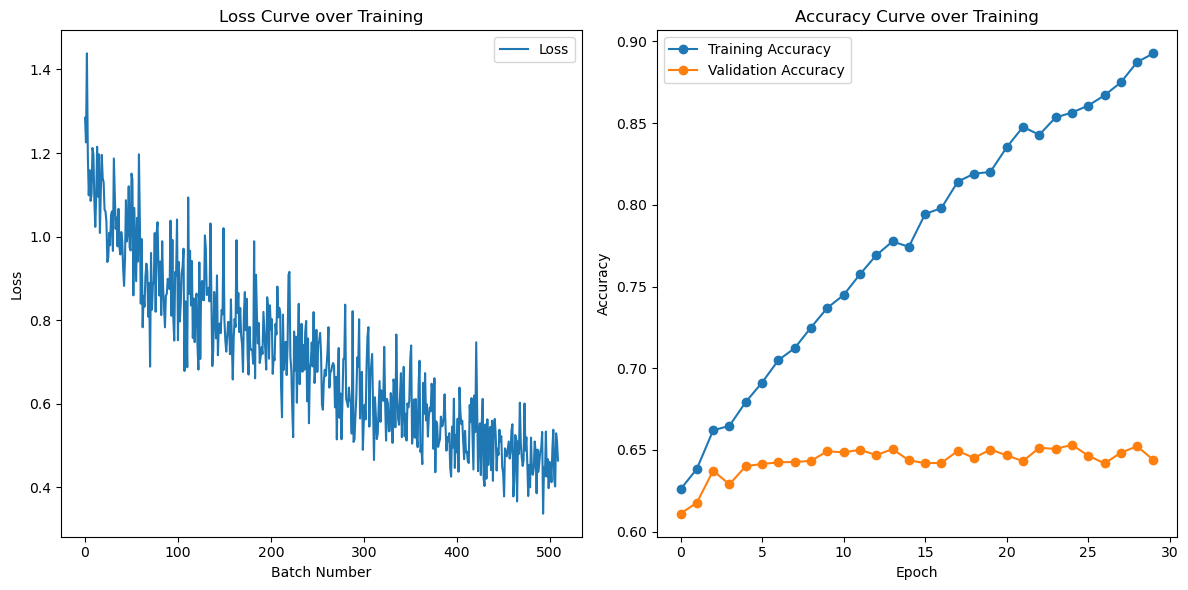

In [6]:
# Create dataloaders
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
if retrain or not os.path.exists(model_save_path):
    train_model(model, NUM_EPOCHS, optimizer, loss_fn, train_loader, test_loader, model_save_path, device, log_every=10)
else:
    model = torch.load(model_save_path, map_location = 'cpu')

### 3. Evaluation

In [7]:
print("Overall Accuracy:")
print(f"\tTraining Set: {evaluate_model(model, DataLoader(train), device)}")
print(f"\tTesting Set: {evaluate_model(model, DataLoader(test), device)}")

print("Accuracy on real data:")
print(f"\tTraining Set: {evaluate_model(model, DataLoader(train_real), device)}")
print(f"\tTesting Set: {evaluate_model(model, DataLoader(test_real), device)}")

print("Accuracy on fake data:")
print(f"\tTraining Set: {evaluate_model(model, DataLoader(train_fake), device)}")
print(f"\tTesting Set: {evaluate_model(model, DataLoader(test_fake), device)}")

Overall Accuracy:
	Training Set: 0.8927364864864865
	Testing Set: 0.6438477951635846
Accuracy on real data:
	Training Set: 0.9330547652916074
	Testing Set: 0.6966571834992887
Accuracy on fake data:
	Training Set: 0.8524182076813656
	Testing Set: 0.5910384068278806


#### Top N Accuracy

In [8]:
real_loader = DataLoader(ConcatDataset([train_real, test_real]), batch_size=BATCH_SIZE, shuffle=False)
fake_loader = DataLoader(ConcatDataset([train_fake, test_fake]), batch_size=BATCH_SIZE, shuffle=False)

In [9]:
def get_top_n_predictions(loader, n):
    predictions = {}

    for embeddings, labels, sku in loader:
        output = model(embeddings.to(device))
        prob, predicted = torch.topk(torch.softmax(output, 1), n)

        for i in range(len(predicted)):
            predictions[sku[i]] = [train_real.id2label[labels[i].item()]] + [train_real.id2label[predicted[i][j].item()] for j in range(n)] + [prob[i][j].item() for j in range(n)]

    df = pd.DataFrame(predictions).T.reset_index()
    df.columns = ['sku'] + ['target'] + [f'pred_{i}' for i in range(n)] + [f'prob_{i}' for i in range(n)]

    df['top1_correct'] = df['target'] == df['pred_0']
    for i in range(1, n):
        df[f'top{i+1}_correct'] = df[f'top{i}_correct'] | (df['target'] == df[f'pred_{i}'])
    return df


In [10]:
real_predictions = get_top_n_predictions(real_loader, 3)
fake_predictions = get_top_n_predictions(fake_loader, 3)

real_predictions['dataset'] = real_predictions.sku.apply(lambda x: 'train' if x in train_real.df.sku.to_list() else 'test')
fake_predictions['dataset'] = fake_predictions.sku.apply(lambda x: 'train' if x in train_fake.df.sku.to_list() else 'test')

In [11]:
print("Real Images:")
for dataset in ['train', 'test']:
    print(f"\t{dataset.capitalize()} Set:")
    for i in range(3):
        print(f"\t\tTop {i+1}: {real_predictions[real_predictions.dataset == dataset][f'top{i+1}_correct'].mean()}")

print("Reconstructed Images:")
for dataset in ['train', 'test']:
    print(f"\t{dataset.capitalize()} Set:")
    for i in range(3):
        print(f"\t\tTop {i+1}: {fake_predictions[fake_predictions.dataset == dataset][f'top{i+1}_correct'].mean()}")

Real Images:
	Train Set:
		Top 1: 0.9330547652916074
		Top 2: 0.989153627311522
		Top 3: 0.9978662873399715
	Test Set:
		Top 1: 0.6966571834992887
		Top 2: 0.8737553342816501
		Top 3: 0.947724039829303
Reconstructed Images:
	Train Set:
		Top 1: 0.8524182076813656
		Top 2: 0.9596372688477952
		Top 3: 0.9885312944523471
	Test Set:
		Top 1: 0.5910384068278806
		Top 2: 0.8076102418207681
		Top 3: 0.9025604551920341


In [12]:
print('Real Images:')
display(real_predictions.groupby('target').top1_correct.mean().sort_values(ascending=False))

print('Reconstructed Images:')
fake_predictions.groupby('target').top1_correct.mean().sort_values(ascending=False)

Real Images:


target
Denim dress                     0.983974
Jumper dress                    0.935646
Occasion wear                   0.924113
Day dress                       0.906506
Maxi dress                      0.866259
Cocktail dress / Party dress    0.856172
Shift dress                     0.831845
Jersey dress                    0.800559
Name: top1_correct, dtype: float64

Reconstructed Images:


target
Denim dress                     0.929487
Occasion wear                   0.881273
Day dress                       0.852127
Jumper dress                    0.843640
Maxi dress                      0.797013
Cocktail dress / Party dress    0.728199
Shift dress                     0.684524
Jersey dress                    0.656983
Name: top1_correct, dtype: float64

In [13]:
pd.crosstab(real_predictions.target, real_predictions.pred_0)

pred_0,Cocktail dress / Party dress,Day dress,Denim dress,Jersey dress,Jumper dress,Maxi dress,Occasion wear,Shift dress
target,,,,,,,,
Cocktail dress / Party dress,1512,113,0,21,13,25,45,37
Day dress,69,4751,9,147,49,176,8,32
Denim dress,0,4,307,0,0,1,0,0
Jersey dress,29,181,0,1433,53,57,13,24
Jumper dress,11,44,0,39,1861,17,1,16
Maxi dress,13,104,1,23,15,1276,38,3
Occasion wear,17,6,0,5,2,31,755,1
Shift dress,22,26,0,29,31,4,1,559


### Check some misclassified examples

In [14]:
def display_missclassified_samples(miss, num_samples=5):
    sample = miss.sample(num_samples)
    fig, ax = plt.subplots(1, num_samples, figsize=(5 * num_samples, 10))

    for i in range(num_samples):
        sku = sample.iloc[i].sku
        img_path = f"{DATA_PATH}/Generated_Images/restyle/inference_results/4/{sku}.jpg"
        img = Image.open(img_path)
        ax[i].imshow(img)

        # Construct title string with predictions and their probabilities
        title_text = f"SKU: {sku}\nTarget: {sample.iloc[i].target}"
        for j in range(3):  # Assuming there are always three predictions to display
            pred_col = f'pred_{j}'
            prob_col = f'prob_{j}'
            title_text += f"\nPrediction {j + 1}: {sample.iloc[i][pred_col]} ({np.round(sample.iloc[i][prob_col], 2)})"

        ax[i].set_title(title_text)
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()


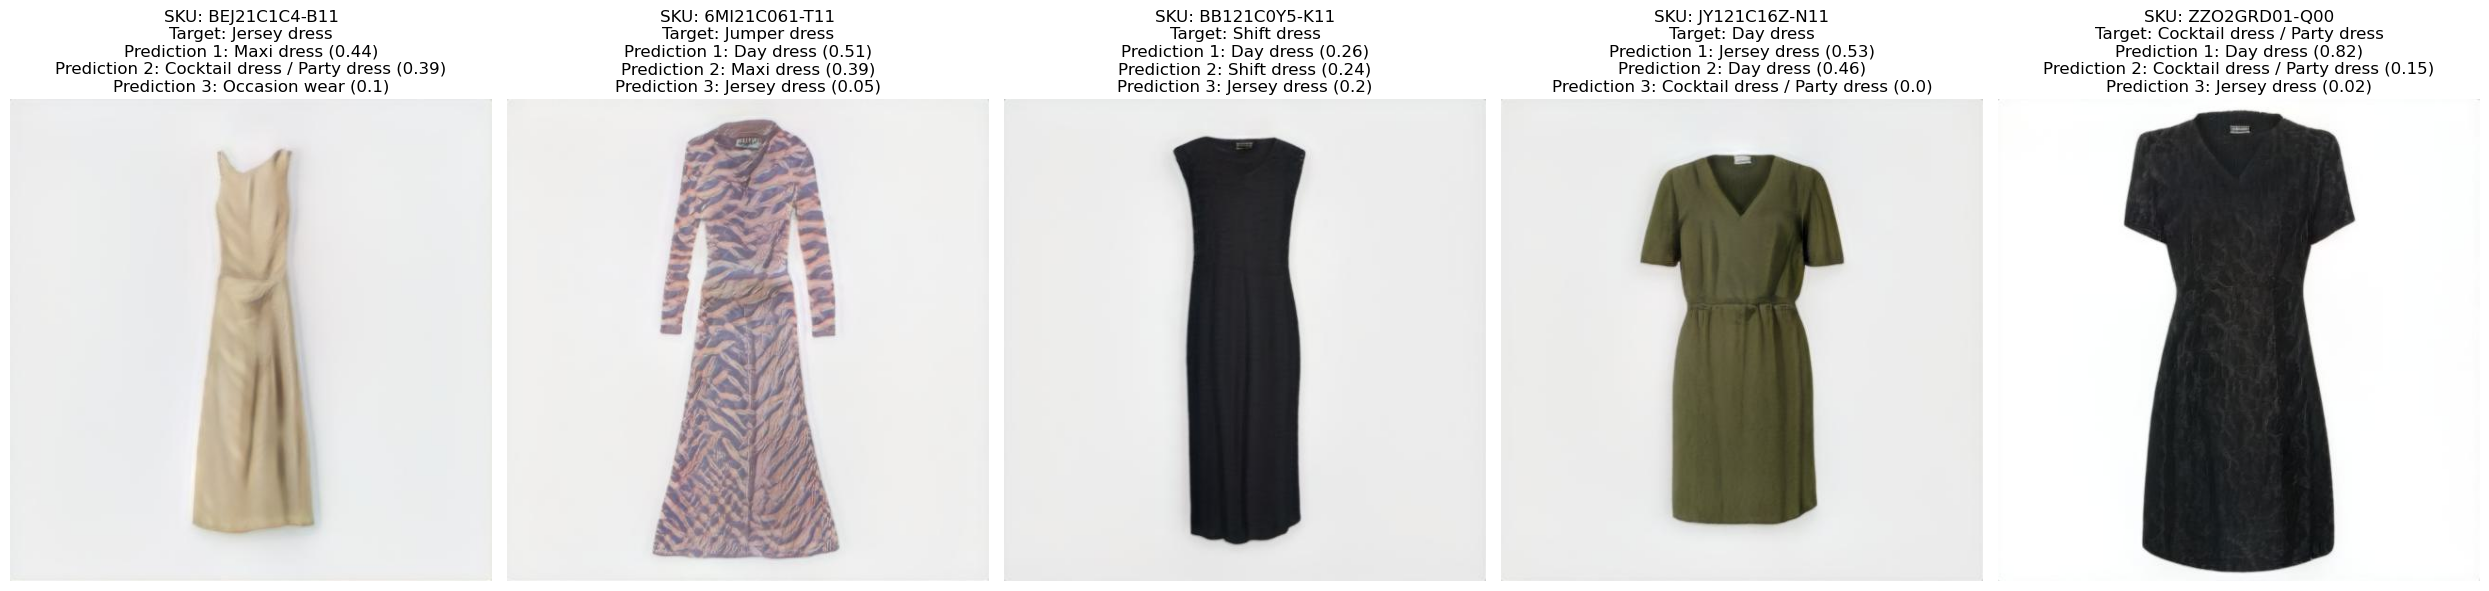

In [15]:
miss = fake_predictions[fake_predictions.target != fake_predictions.pred_0]
display_missclassified_samples(miss, 5)